In [1]:
import os
import numpy as np
import trimesh
import pyrender
import h5py
from mesh_to_png import mesh_to_png
from landmarks import detect_landmark
from data_def import PCAModel, Mesh
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
from collections import namedtuple

In [2]:
# Load Data
bfm = h5py.File("model2017-1_face12_nomouth.h5", 'r')
mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))
triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T
# PCA model for facial identity
mu_id = np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_id = np.asarray(bfm['shape/model/pcaBasis'], dtype=np.float32)
pcaVariance_id = np.asarray(bfm['shape/model/pcaVariance'], dtype=np.float32)
# PCA model for expression
mu_exp = np.asarray(bfm['expression/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_exp = np.asarray(bfm['expression/model/pcaBasis'], dtype=np.float32)
pcaVariance_exp = np.asarray(bfm['expression/model/pcaVariance'], dtype=np.float32)
E_id = pcaBasis_id[:,:30].reshape((-1,3,30))
E_exp = pcaBasis_exp[:,:20].reshape((-1,3,20))
sigma_id = np.sqrt(pcaVariance_id[:30])
sigma_exp = np.sqrt(pcaVariance_exp[:20])

In [3]:
# Extract ground truth landmarks.
# For Leo.
face_image = mpimg.imread('leo.jpg')
# For doge.
# face_image = mpimg.imread('doge.png')
# face_image = (face_image[:, :, :3] * 256).astype(np.uint8)

face_landmarks_gt = detect_landmark(face_image)
H, W = face_image.shape[0], face_image.shape[1]
# Visualize facial landmark points on the 2D image plane.
landmark_index=[]
with open('Landmarks68_model2017-1_face12_nomouth.anl','r') as f:
    for line in f.readlines():
        landmark_index.append(int(line.split('\n')[0]))


In [4]:
def get_transformation(omega,t):
    # Define Rotation matrix.
    Rx, Ry, Rz = torch.zeros(3, 3), torch.zeros(3, 3), torch.zeros(3, 3)
    Rx[0, 0] = 1.
    Rx[1, 1] = torch.cos(omega[0])
    Rx[1, 2] = -torch.sin(omega[0])
    Rx[2, 1] = torch.sin(omega[0])
    Rx[2, 2] = torch.cos(omega[0])

    Ry[0, 0] = torch.cos(omega[1])
    Ry[0, 2] = torch.sin(omega[1])
    Ry[1, 1] = 1.
    Ry[2, 0] = -torch.sin(omega[1])
    Ry[2, 2] = torch.cos(omega[1])
    
    Rz[0, 0] = torch.cos(omega[2])
    Rz[0, 1] = -torch.sin(omega[2])
    Rz[1, 0] = torch.sin(omega[2])
    Rz[1, 1] = torch.cos(omega[2])
    Rz[2, 2] = 1.
    
    R = Rx @ Ry @ Rz    
    T = torch.cat((torch.cat((R, t.view(-1, 1)), dim=1), torch.tensor([0., 0., 0., 1.]).view(1, -1)), dim=0)   
    return T

def get_projection(W, H, f, n, fovy):
    # Define camera projection matrices.
    V = torch.Tensor([[W/2, 0, 0, W/2],
                      [0, -H/2, 0, H/2],
                      [0, 0, 0.5, 0.5],
                      [0, 0, 0, 1]
                     ])

    aspect_ratio = W / H
    t = np.tan(fovy / 2) * n
    b = -t
    r = t * aspect_ratio
    l = -t * aspect_ratio
    P = torch.Tensor([[(2*n)/(r-l),0,(r+l)/(r-l),0],
                  [0,(2*n)/(t-b),(t+b)/(t-b),0],
                  [0,0,-(f+n)/(f-n),-(2*f*n)/(f-n)],
                  [0,0,-1,0]])
    return V, P

Epoch: 0, L_landmark: 18333.2734, L_regularizer: 1.1137, L_fit:18334.3867
Epoch: 10, L_landmark: 13937.7090, L_regularizer: 35.4636, L_fit:13973.1729
Epoch: 20, L_landmark: 10172.5908, L_regularizer: 127.5577, L_fit:10300.1484
Epoch: 30, L_landmark: 7395.7095, L_regularizer: 242.8730, L_fit:7638.5825
Epoch: 40, L_landmark: 5385.0713, L_regularizer: 346.4919, L_fit:5731.5635
Epoch: 50, L_landmark: 3866.8362, L_regularizer: 420.7157, L_fit:4287.5518
Epoch: 60, L_landmark: 2767.9497, L_regularizer: 468.5530, L_fit:3236.5027
Epoch: 70, L_landmark: 2026.9385, L_regularizer: 490.1423, L_fit:2517.0808
Epoch: 80, L_landmark: 1582.1124, L_regularizer: 503.4354, L_fit:2085.5479
Epoch: 90, L_landmark: 1324.5730, L_regularizer: 493.4717, L_fit:1818.0447
Epoch: 100, L_landmark: 1246.3949, L_regularizer: 471.2139, L_fit:1717.6088
Epoch: 110, L_landmark: 988.8122, L_regularizer: 457.3693, L_fit:1446.1815
Epoch: 120, L_landmark: 950.8336, L_regularizer: 440.4516, L_fit:1391.2852
Epoch: 130, L_landmark

Epoch: 100, L_landmark: 1237.4592, L_regularizer: 546.7279, L_fit:1784.1871
Epoch: 110, L_landmark: 1068.8488, L_regularizer: 525.9229, L_fit:1594.7716
Epoch: 120, L_landmark: 1042.3834, L_regularizer: 505.9418, L_fit:1548.3252
Epoch: 130, L_landmark: 962.3404, L_regularizer: 483.6479, L_fit:1445.9883
Epoch: 140, L_landmark: 993.5561, L_regularizer: 463.8558, L_fit:1457.4119
Epoch: 150, L_landmark: 893.1850, L_regularizer: 444.6086, L_fit:1337.7937
Epoch: 160, L_landmark: 836.1806, L_regularizer: 426.0563, L_fit:1262.2369
Epoch: 170, L_landmark: 978.4818, L_regularizer: 410.1663, L_fit:1388.6481
Epoch: 180, L_landmark: 830.3063, L_regularizer: 395.6355, L_fit:1225.9418
Epoch: 190, L_landmark: 780.3218, L_regularizer: 382.0745, L_fit:1162.3964
Epoch: 200, L_landmark: 727.2596, L_regularizer: 370.6801, L_fit:1097.9397
Epoch: 210, L_landmark: 705.9351, L_regularizer: 362.2934, L_fit:1068.2285
Epoch: 220, L_landmark: 796.0314, L_regularizer: 352.7451, L_fit:1148.7765
Epoch: 230, L_landmark

Epoch: 260, L_landmark: 793.4459, L_regularizer: 374.2304, L_fit:1167.6763
Epoch: 270, L_landmark: 835.6036, L_regularizer: 364.9038, L_fit:1200.5074
Epoch: 280, L_landmark: 1048.6021, L_regularizer: 356.5141, L_fit:1405.1162
Epoch: 290, L_landmark: 780.4116, L_regularizer: 345.3442, L_fit:1125.7559
Epoch: 300, L_landmark: 778.5873, L_regularizer: 336.7162, L_fit:1115.3035
Epoch: 310, L_landmark: 865.8424, L_regularizer: 329.2786, L_fit:1195.1210
Epoch: 320, L_landmark: 779.3552, L_regularizer: 323.3670, L_fit:1102.7223
Epoch: 330, L_landmark: 795.4224, L_regularizer: 317.0941, L_fit:1112.5166
Epoch: 340, L_landmark: 777.9717, L_regularizer: 312.5927, L_fit:1090.5645
Epoch: 350, L_landmark: 766.9380, L_regularizer: 307.0084, L_fit:1073.9464
Epoch: 360, L_landmark: 723.3659, L_regularizer: 302.8196, L_fit:1026.1855
Epoch: 370, L_landmark: 730.8975, L_regularizer: 298.1285, L_fit:1029.0260
Epoch: 380, L_landmark: 726.4603, L_regularizer: 293.9379, L_fit:1020.3981
Epoch: 390, L_landmark: 

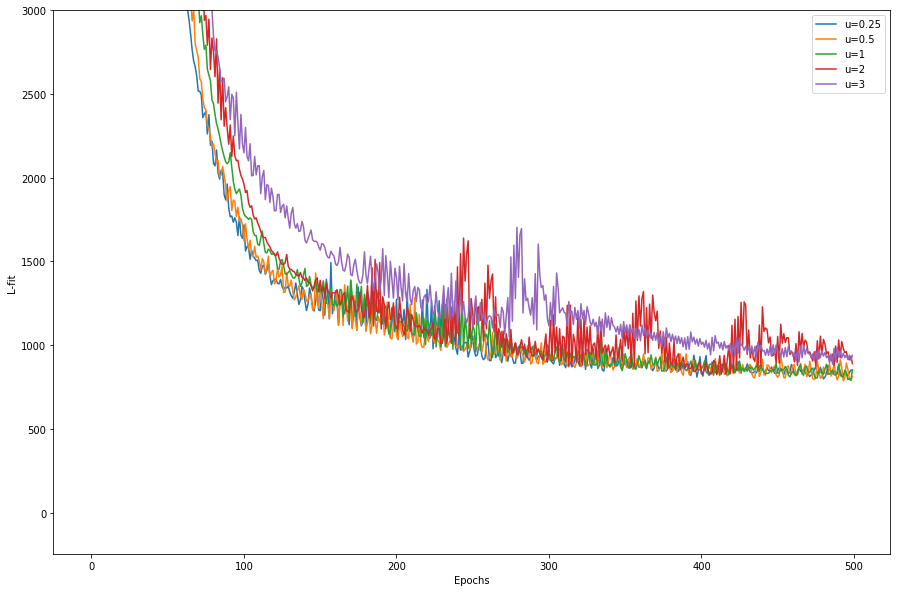

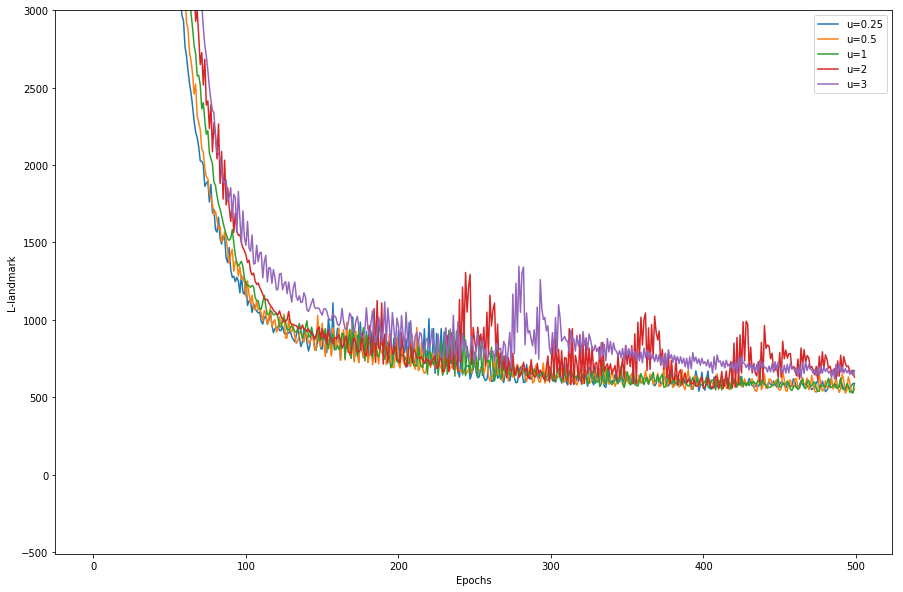

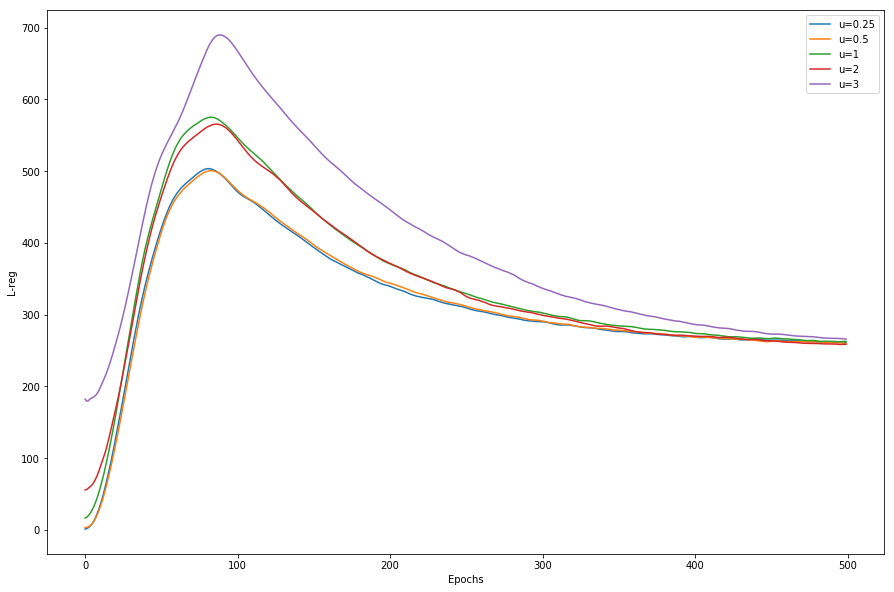

In [10]:
# Define Hyperparameters.
epochs = 500
lambda_alpha,lambda_delta= 1,1
fovy,near,far =0.5,300., 2000.

# Convert data to PyTorch tensors.
mu_id_torch = torch.Tensor(mu_id[landmark_index,:])
mu_exp_torch = torch.Tensor(mu_exp[landmark_index,:])
E_id_torch = torch.Tensor(E_id[landmark_index,:,:])
E_exp_torch = torch.Tensor(E_exp[landmark_index,:,:])
sigma_id_torch = torch.Tensor(sigma_id)
sigma_exp_torch = torch.Tensor(sigma_exp)



# Define camera projection matrices.
V, P = get_projection(W, H, far, near, fovy)
tot_losses_land = []
tot_losses_reg = []
tot_losses_fit = []
for uni in [0.25, 0.5, 1, 2, 3]:
    # Initialize trainable variables.
    gt_landmark = torch.Tensor(face_landmarks_gt).t()
    alpha_torch = Variable(torch.FloatTensor(30).uniform_(-uni, uni), requires_grad=True)
    delta_torch = Variable(torch.FloatTensor(20).uniform_(-uni, uni), requires_grad=True)
    omega = Variable(torch.zeros(3), requires_grad=True)
    t = Variable(torch.Tensor([0, 0, -400]), requires_grad=True)

    # Initialize optimizer.
    opt = torch.optim.Adam([alpha_torch, delta_torch, omega, t], lr=0.1)    
    losses_land = []
    losses_reg = []
    losses_fit = []
    for epoch in np.arange(epochs):
        opt.zero_grad()    
        G = mu_id_torch + E_id_torch @ (alpha_torch  * sigma_id_torch) + mu_exp_torch + E_exp_torch @ (delta_torch * sigma_exp_torch)    
        G_landmark = torch.cat((torch.transpose(G,0,1), torch.ones(1, len(landmark_index))), 0)

        # Get Transformation
        T = get_transformation(omega,t)

        out = V @ P @ T @ G_landmark
        pred_landmark = out[:2, :] / out[3, :]

        L_landmark = (pred_landmark - gt_landmark).pow(2).sum(dim=0).sqrt().sum()
        L_regularizer = lambda_alpha * alpha_torch.pow(2).sum() + lambda_delta * delta_torch.pow(2).sum()
        L_fit = L_landmark + L_regularizer
        L_fit.backward(retain_graph=True)
        opt.step()    
        losses_land.append(L_landmark.item())
        losses_reg.append(L_regularizer)
        losses_fit.append(L_fit.item())
        if epoch % 10 ==0:
            print('Epoch: {}, L_landmark: {:.4f}, L_regularizer: {:.4f}, L_fit:{:.4f}'.format(epoch, L_landmark, L_regularizer,L_fit))
    tot_losses_land.append(losses_land)
    tot_losses_reg.append(losses_reg)
    tot_losses_fit.append(losses_fit)

unis = [0.25, 0.5, 1, 2, 3]
# Plot losses.
fig = plt.figure(figsize= (15, 10))
for i, losses_fit in enumerate(tot_losses_fit):

    plt.plot(np.arange(epochs), losses_fit, label='u={}'.format(unis[i]))
plt.xlabel('Epochs')
plt.ylabel('L-fit')
plt.legend()
plt.ylim(top=3000)
plt.show()
fig.savefig('results/fit_losses_uniform.png')

fig = plt.figure(figsize=(15, 10))
for i, losses_land in enumerate(tot_losses_land):
    plt.plot(np.arange(epochs), losses_land, label='u={}'.format(unis[i]))
plt.xlabel('Epochs')
plt.ylabel('L-landmark')
plt.legend()
plt.ylim(top=3000)
plt.show()
fig.savefig('results/lan_losses_uniform.png')

fig = plt.figure(figsize=(15, 10))
for i, losses_reg in enumerate(tot_losses_reg):
    plt.plot(np.arange(epochs), losses_reg, label='u={}'.format(unis[i]))
plt.xlabel('Epochs')
plt.ylabel('L-reg')
plt.legend()
plt.show()
fig.savefig('results/reg_losses_uniform.png')